<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/tim-updates/code/tim-wiki-eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wikipedia Article EDA Notebook

In [1]:
import sys

!{sys.executable} -m pip install spacy -U -q
!{sys.executable} -m spacy download en_core_web_lg -q

2022-09-25 20:34:27.051409: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
     |████████████████████████████████| 587.7 MB 9.9 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [2]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
urls = ['https://raw.githubusercontent.com/Tstrebe2/predicting-text-difficulty/main/assets/dale_chall.txt',
        'https://raw.githubusercontent.com/Tstrebe2/predicting-text-difficulty/main/assets/Concreteness_ratings_Brysbaert_et_al_BRM.txt',
        'https://raw.githubusercontent.com/Tstrebe2/predicting-text-difficulty/main/assets/AoA_51715_words.csv',
        'https://raw.githubusercontent.com/Tstrebe2/predicting-text-difficulty/main/assets/WikiLarge_Train.csv',
        'https://raw.githubusercontent.com/Tstrebe2/predicting-text-difficulty/main/assets/WikiLarge_Test.csv',
        'https://raw.githubusercontent.com/Tstrebe2/predicting-text-difficulty/main/assets/sampleSubmission.csv']

d_chall = requests.get(urls[0]).text.split('\r')
conc_df = pd.read_csv(urls[1], sep='\t')
aoa_df = pd.read_csv(urls[2], encoding_errors='ignore')

wiki_df_train = pd.read_csv(urls[3])
# The labels column is purely null values so I'm going to throw it away
wiki_df_test = pd.read_csv(urls[4], usecols=['id', 'original_text']).set_index('id')
sample_df = pd.read_csv(urls[5]).set_index('id')

## Sentence Lengths and Word Counts

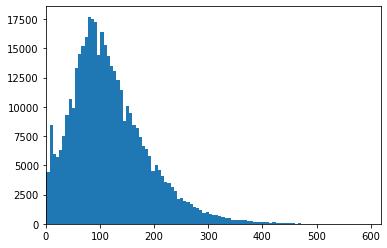

In [ ]:
def plot_sentence_character_lengths(wiki_df):
  sentence_lengths = wiki_df['original_text'].apply(len)
  plt.hist(sentence_lengths, bins=100)
  plt.xlim(0)
  plt.show()

plot_sentence_character_lengths(wiki_df_train)

Top 10 sentences with 3 or less characters

In [80]:
(wiki_df_train[wiki_df_train['original_text'].apply(len) < 4]
 ['original_text']
 .value_counts()
 .sort_values(ascending=False)
 .head(10))

!      111
.      109
The     55
C.      25
New     17
A       17
--      17
jpg     15
,       13
png     13
Name: original_text, dtype: int64

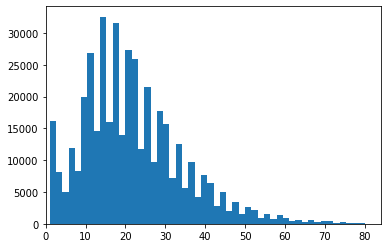

In [134]:
def plot_sentence_word_counts(wiki_df):
  # For this exerices I will use the Python split method to tokenize my sentences
  word_freqs = wiki_df['original_text'].apply(lambda x: len(x.split(' ')))
  plt.hist(word_freqs, bins=50)
  plt.xlim(0)
  plt.show()

plot_sentence_word_counts(wiki_df_train)

Top 12 sentences with two or less tokens

In [78]:
(wiki_df_train[wiki_df_train['original_text'].apply(lambda x: len(x.split(' '))) < 3]
 ['original_text']
 .value_counts()
 .sort_values(ascending=False)
 .head(12))

References        1051
Other websites     612
Other pages        417
History            265
Official           159
Deaths             142
Events             140
Births             123
!                  111
.                  109
-- -RRB-           108
#NAME?              63
Name: original_text, dtype: int64

## Visulaization of word and n-grams counts

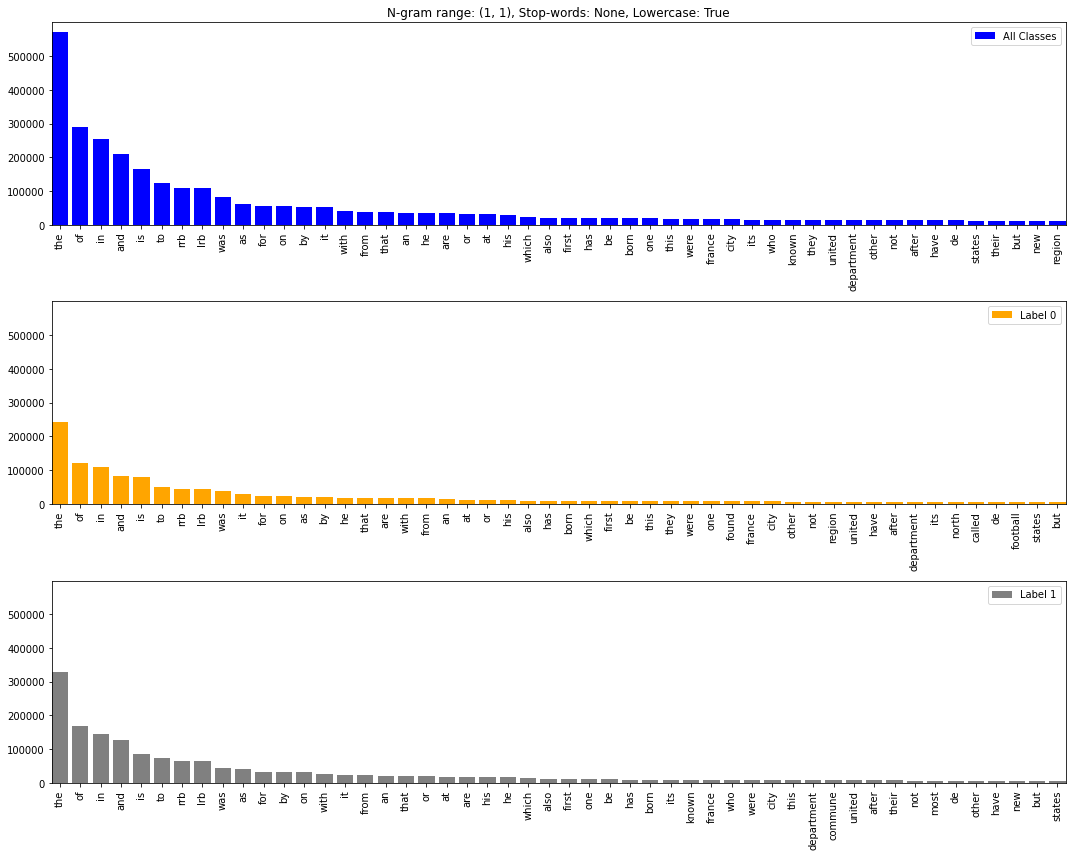

In [141]:
def plot_top_50_word_freq(wiki_df, ngram_range=(1, 1), stop_words=None, lowercase=True):
  args = {}
  args['ngram_range'] = ngram_range
  args['stop_words'] = stop_words
  args['lowercase'] = lowercase

  vectorizer = CountVectorizer(**args).fit(wiki_df_train['original_text'])
  X_transformed = vectorizer.transform(wiki_df_train['original_text'])
  y = wiki_df_train.label.values

  X_all = np.array(X_transformed.sum(axis=0))[0]
  X_0 = np.array(X_transformed[np.where(y == 0)].sum(axis=0))[0]
  X_1 = np.array(X_transformed[np.where(y == 1)].sum(axis=0))[0]

  fig, axs = plt.subplots(nrows=3, figsize=(15, 12), sharey=True)
  axs[0].set_title(f'N-gram range: {ngram_range}, Stop-words: {stop_words}, Lowercase: {lowercase}')
  for X, ax, label, color in zip((X_all, X_0, X_1), 
                          axs, 
                          ('All Classes', 'Label 0', 'Label 1'),
                          ('blue', 'orange', 'grey')):
    top_50_ix = np.argsort(-X)[:50]
    top_50 = X[top_50_ix]
    top_50_words = np.array(vectorizer.get_feature_names_out())[top_50_ix]

    ax.bar(top_50_words, top_50, label=label, color=color)
    for tick in ax.get_xticklabels():
      tick.set_rotation(90)
    ax.autoscale(enable=True, axis='x', tight=True)
    ax.legend()

  fig.tight_layout()
  plt.show()

plot_top_50_word_freq(wiki_df_train)

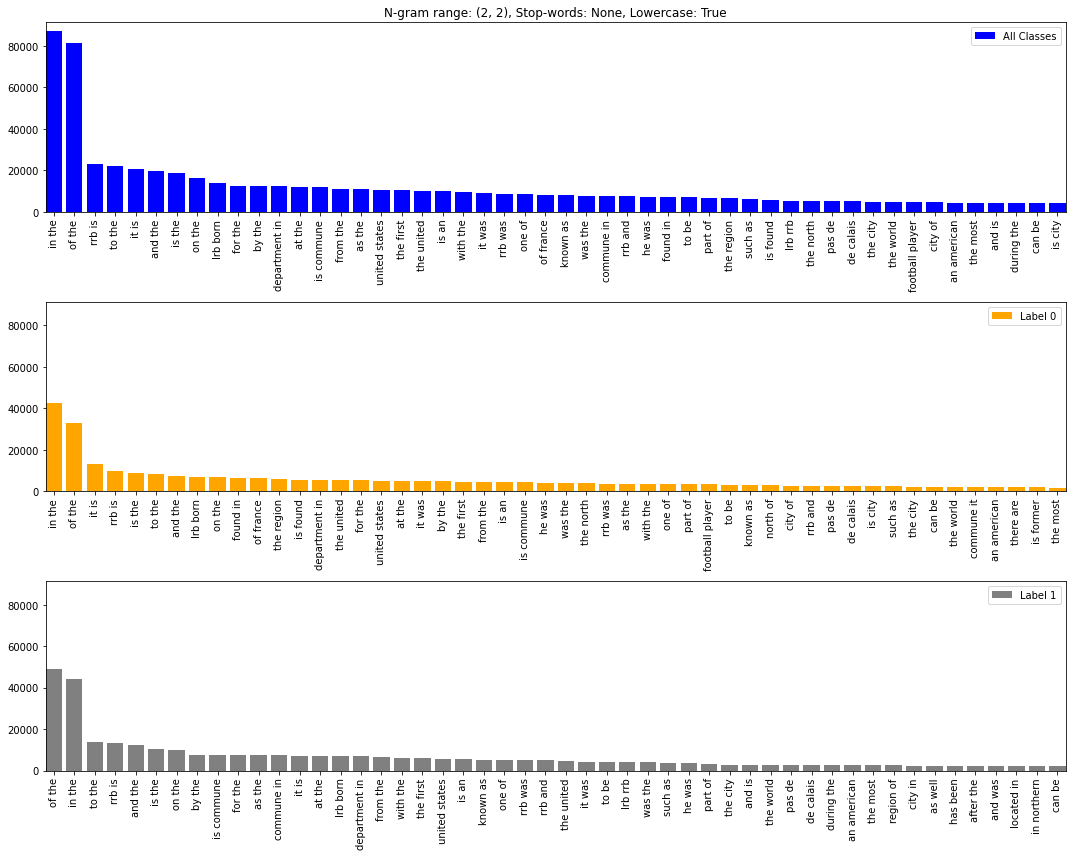

In [129]:
plot_top_50_word_freq(wiki_df_train, ngram_range=(2, 2))

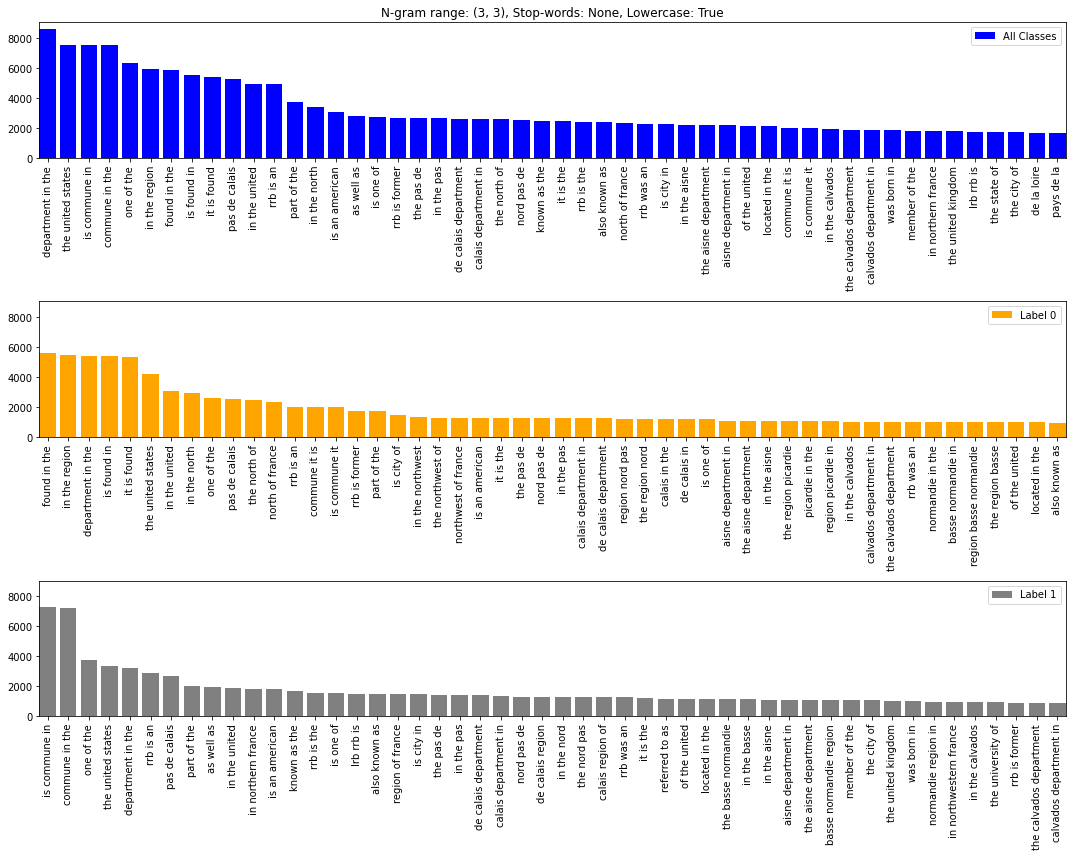

In [130]:
plot_top_50_word_freq(wiki_df_train, ngram_range=(3, 3))

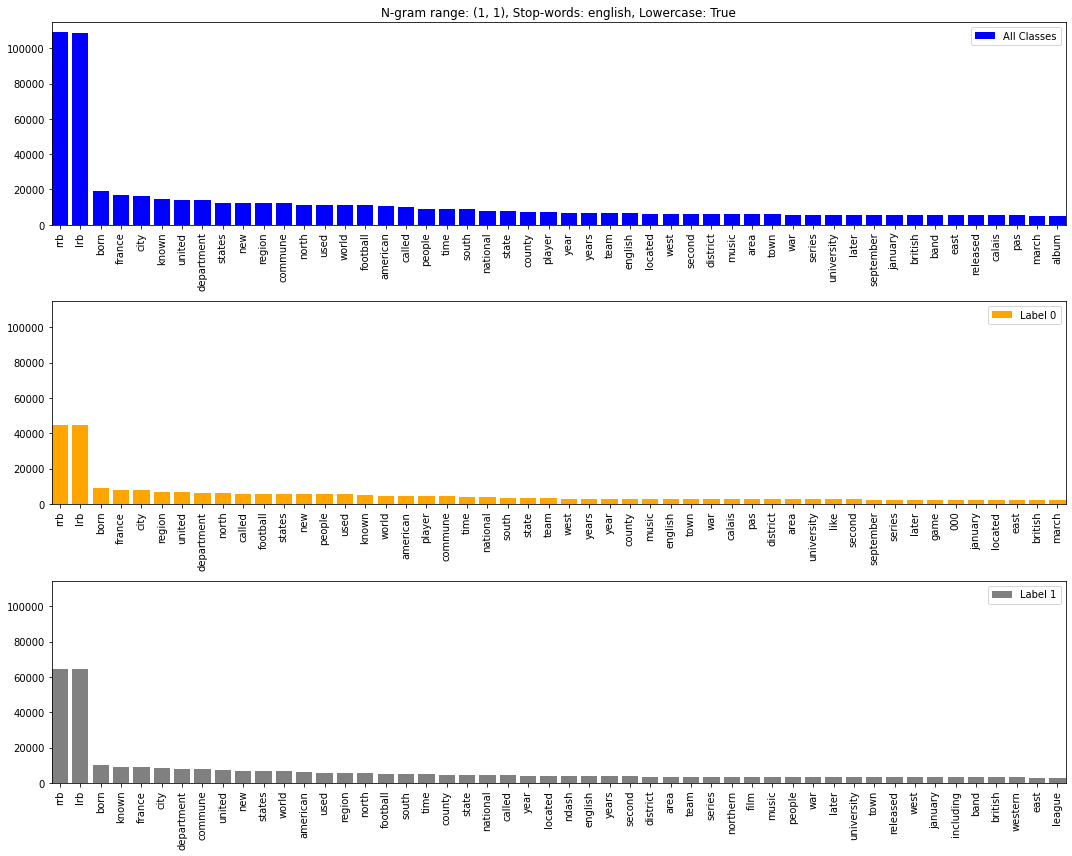

In [131]:
plot_top_50_word_freq(wiki_df_train, ngram_range=(1, 1), stop_words='english')

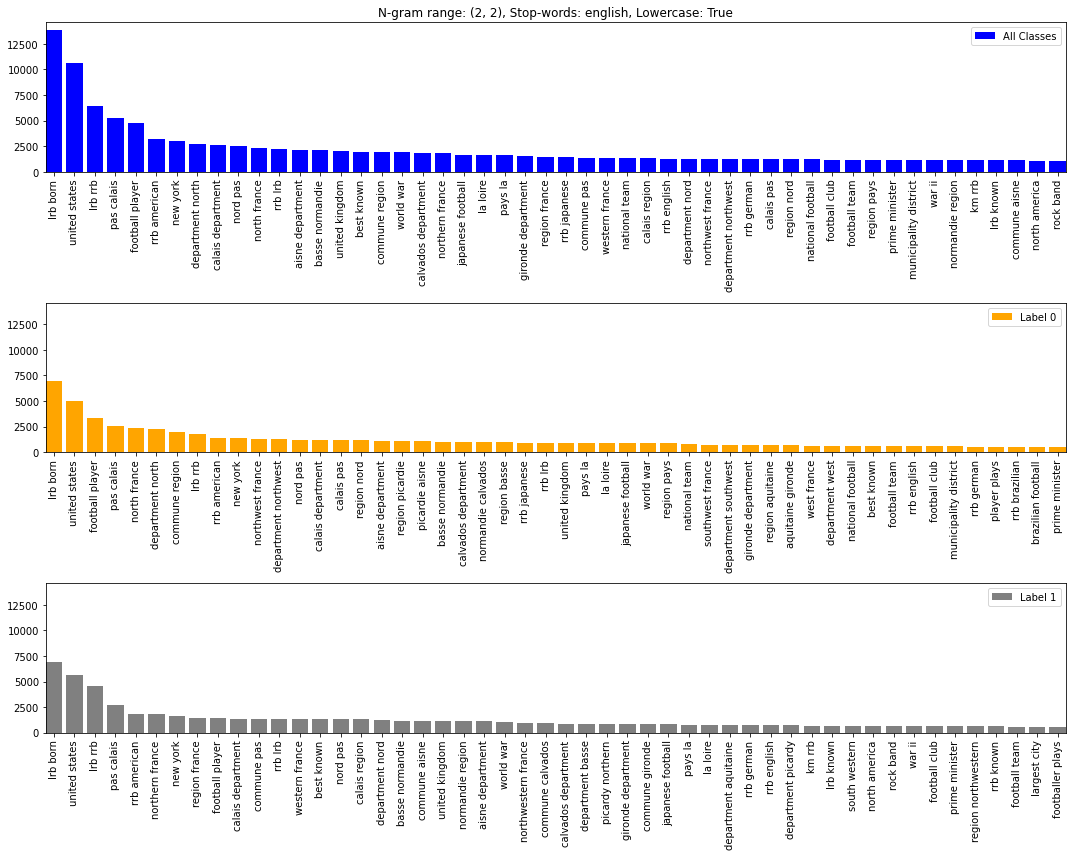

In [132]:
plot_top_50_word_freq(wiki_df_train, ngram_range=(2, 2), stop_words='english')

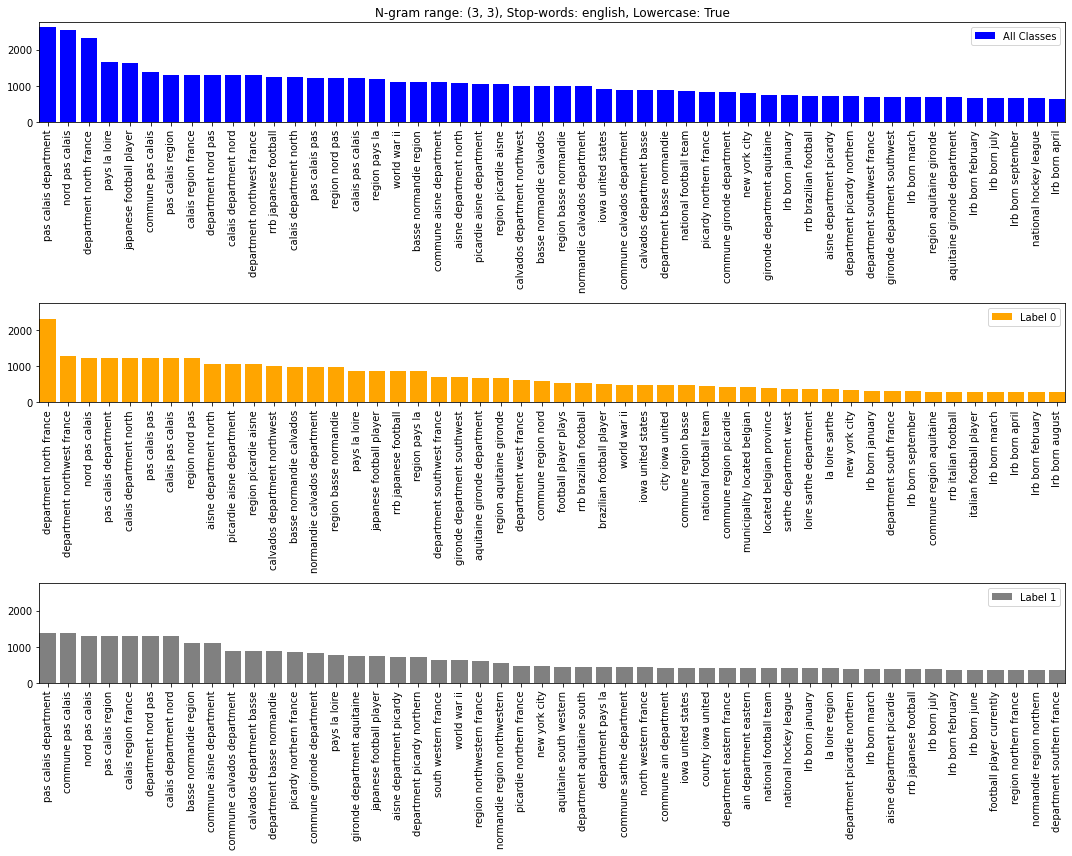

In [133]:
plot_top_50_word_freq(wiki_df_train, ngram_range=(3, 3), stop_words='english')

## Visualization of TF-IDF

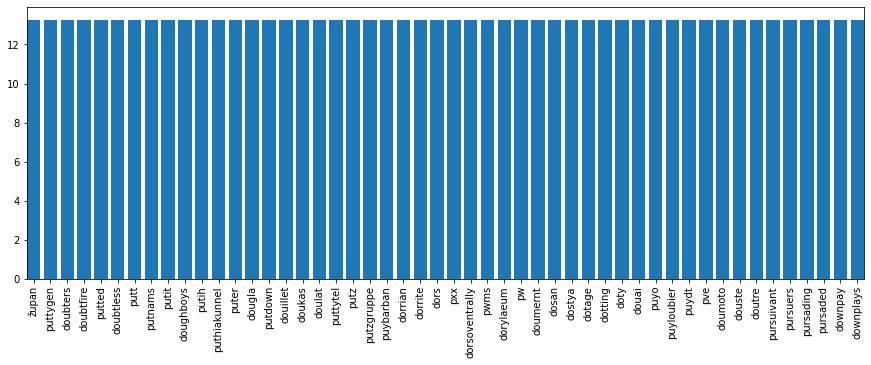

In [155]:
def plot_top_50_tfidf(wiki_df):
  vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, use_idf=True).fit(wiki_df['original_text'])
  
  feature_names = np.array(vectorizer.get_feature_names_out())

  top_50_ix = np.argsort(-vectorizer.idf_)[:50]
  top_50 = vectorizer.idf_[top_50_ix]
  top_50_names = feature_names[top_50_ix]

  plt.figure(figsize=(15, 5))
  plt.bar(top_50_names, top_50)
  plt.xticks(rotation=90)
  plt.autoscale(enable=True, axis='x', tight=True)

plot_top_50_tfidf(wiki_df_train)

## Visulaization of word and n-grams counts (With Lemmas)

In [ ]:
# I am going to use SpaCy to lemmatize since it's fast and accurate
import spacy

nlp = spacy.load('en_core_web_lg', disable=('tok2Vec', 'parser', 'ner'))

def get_lemmatized_text(text):
  doc = nlp(text)
  return ' '.join([t.lemma_ for t in doc])

wiki_df_train['lemmatized_text'] = wiki_df_train['original_text'].apply(get_lemmatized_text)